# Итоговый отчет
## Дарья Вальтер, БПМИ141



### Программные средства:
- python 3.5, numpy и т.д.
- Django

### Модули и сигнатуры функций
#### Решение СЛУ

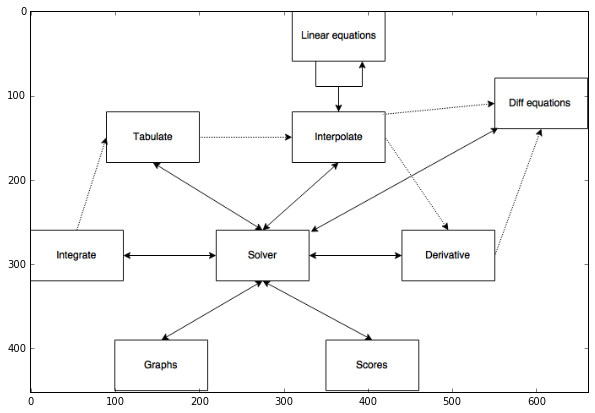

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
img=plt.imread('Diagram.png')
plt.figure(figsize=(10,8))
plt.imshow(img)

In [4]:
# INPUTS
# A: np.array((n, m)) - матрица уравнений
# B: np.array((n, 1)) - вектор ответов
#
# RETURNS
# roots
def kramer(A, F):
    det = np.linalg.det(A)
    if not det:
        raise RuntimeError("Determinant equals to 0.")
    roots = []
    for x in range(A.shape[1]):
        tmp = A.copy()
        tmp[:, x] = F
        roots.append(float(np.linalg.det(tmp)) / det)
    return roots

#### Модуль табуляции

In [6]:
# INPUTS
# function: lambda expression
# grid: np.array((n)) - сетка табуляции
#
# RETURNS
# табулированная функция
def tabulate(function, grid):
    values = np.array([function(x) for x in grid])
    return TabulatedFunction(values, grid)

#### Модуль интерполяции кубическими сплайнами

In [7]:
# INPUTS
# tabulated_function: табулированная функция
#
# RETURNS
# интерполяция - callable object
def interpolate(tabulated_function):

    grid = tabulated_function.grid
    N = len(grid) - 2
    matrix = np.zeros((N, N))
    values = np.zeros(N)
    for i in range(1, N+1):

        h_0 = grid[i] - grid[i-1]
        h_1 = grid[i+1] - grid[i]

        if i != 1:
            matrix[i-1, i-2] = h_0
        if i != N:
            matrix[i-1, i] = h_1

        matrix[i-1, i-1] = 2*(h_0 + h_1)
        delta_1 = float(tabulated_function[i+1] - tabulated_function[i])
        delta_0 = float(tabulated_function[i] - tabulated_function[i-1])
        values[i-1] = 6 * (delta_1 / h_1 - delta_0 / h_0)
    derivatives_2 = kramer(matrix, values)

    splines = []
    for i in range(N+1):
        der2_0 = float(derivatives_2[i-1] if i != 0 else 0)
        der2_1 = float(derivatives_2[i] if i != N else 0)

        h = grid[i+1] - grid[i]
        der3 = (der2_1 - der2_0) / h

        f0 = float(tabulated_function[i])
        f1 = float(tabulated_function[i+1])

        der1 = (f1 - f0) / h - der2_1 * h / 6 - der2_0 * h / 3

        p = Polinomial(3, [f0, der1, der2_0 / 2, der3 / 6], grid[i])
        splines.append(p)
    return Interpolation(splines, tabulated_function.grid)

#### Модуль интегрирования методом Симпсона

In [8]:
# INPUTS
# func: lambda функция
# nnodes: количество узлов в сетке
# interval: интервал интегрирования
#
# RETURNS
# интеграл - число
def integrate(func, nnodes, interval):
    xnet = np.linspace(interval[0], interval[1], nnodes)
    I = 0
    for i in range(nnodes - 1):
        I += (float(xnet[i + 1] - xnet[i]) / 6) * float(func(xnet[i]) + 4 * func(0.5 * (xnet[i] + xnet[i + 1])) + func(xnet[i + 1]))
    return I

#### Модуль дифференцирования
Использован метод дифференцирования интерполяции кублическими сплайнами

In [9]:
# INPUTS
# интерполяция функции кубическими сплайнами
#
# RETURNS
# интерполяция производной
def derivative_interpolation(interpolation):
    derivative_polinomials = []
    for pol in interpolation.splines:
        new_coefs = []
        for i in range(1, len(pol.coefs)):
            new_coefs.append(i * pol.coefs[i])
        derivative_polinomials.append(Polinomial(pol.degree-1, new_coefs, pol.x0))
    new_interpolation = Interpolation(derivative_polinomials, interpolation.grid)
    return new_interpolation

In [10]:
# TEST derivative_interpolation

In [11]:
grid = np.linspace(0, 10, 100)
vals = np.sin(grid)
interpol = interpolate(TabulatedFunction(vals, grid))

In [12]:
deriv = derivative_interpolation(interpol)
der_values = [deriv(x) for x in grid]

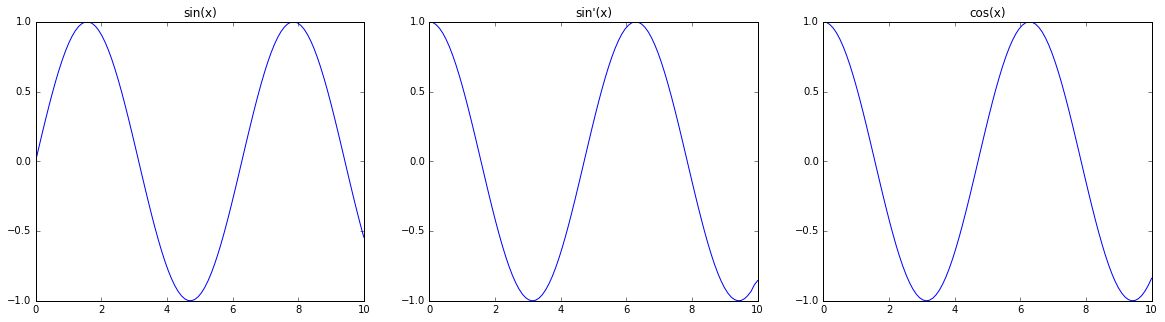

In [13]:
fig, axis = plt.subplots(ncols=3, nrows=1, figsize=(20,5))

axis[0].plot(grid, vals)
axis[0].set_title("sin(x)")

axis[1].plot(deriv.grid, der_values)
axis[1].set_title("sin'(x)")

axis[2].plot(grid, np.cos(grid))
axis[2].set_title("cos(x)")

#### Решение задачи Коши
Метод Эйлера

In [14]:
# INPUTS
# func1: lambda функция
# func2: lambda функция
#
# RETURNS
# табулированная x
# табулированная y
def diff_equastions(func1, func2, x_0, y_0, grid):
    x = [x_0,]
    y = [y_0,]
    step = grid[1] - grid[0]
    for i in range(1, len(grid)):
        x_old = x[i - 1]
        y_old = y[i - 1]
        t_old = grid[i - 1]
        x_new = x_old + step * func1(t_old, y_old)
        y_new = y_old + step * func2(t_old, x_old)
        if y_new < 0 or y_new > 1:
            raise RuntimeError("Y must be in [0, 1]. Specify another beta.")
        x.append(x_new)
        y.append(y_new)
    return TabulatedFunction(np.array(x), grid), TabulatedFunction(np.array(y), grid)

#### Подсчет критериев

In [15]:
def C1_score(x_interpol, y_interpol, rho, nnodes, tgrid, T):
    integrand_dw = lambda w: w*rho(w)
    intergral_dw = lambda t: integrate(func=integrand_dw, nnodes=nnodes, interval=[y_interpol(t), 1])
    integral_tab = tabulate(intergral_dw, grid=tgrid)
    intergral_interpol = interpolate(tabulated_function=integral_tab)
    x_deriv_interpol = derivative_interpolation(x_interpol)
    integrand_dt = lambda t: x_deriv_interpol(t) * intergral_dw(t)
    integral_dt = integrate(func=integrand_dt, nnodes=nnodes, interval=[0, T])
    C1 = 1 - integral_dt / (x_interpol(T) - x_interpol(0))
    return C1

In [16]:
def C2_score(x_interpol, S, T):
    return abs(x_interpol(T) - S(T)) / S(T)

In [17]:
def Loss(C1_score, C2_score):
    return C1_score + 10*C2_score

#### Построение графиков, запись результата в файл

In [37]:
def build_res_graphs(solutions):
    fig, axis = plt.subplots(ncols=3, nrows=len(solutions), figsize=(15,5*len(solutions)))
    if len(solutions) == 1:
        sol = solutions[0]
        axis[0].plot(sol.y_tab.grid, sol.y_tab.values, linewidth=2)
        axis[0].set_title("y(t)", fontsize=14)
        axis[0].set_xlabel("t", fontsize=14)
        axis[0].set_ylabel("y(t)", fontsize=14)

        axis[1].plot(sol.x_tab.values, sol.S_tab.values, linewidth=2)
        axis[1].set_title("S(x)", fontsize=14)
        axis[1].set_xlabel("x(t)", fontsize=14)
        axis[1].set_ylabel("S(t)", fontsize=14)

        axis[2].text(0.5, 0.5, "y(0) = " + str(sol.y_0) + "\n\nx(0) = " + str(sol.x_0) + "\n\nbeta = " + str(sol.beta) +
                     "\n\nC1(beta) = " + str(round(sol.C1, 3)) + "\n\nC2(beta) = " + str(round(sol.C2, 3)) +
                     "\n\nLoss(C1, C2) = " + str(round(sol.loss, 3)),
                     size=16, ha='center', va='center')
    else:
        for i in range(len(solutions)):
            sol = solutions[i]
            axis[i][0].plot(sol.y_tab.grid, sol.y_tab.values, linewidth=2)
            axis[i][0].set_title("y(t)", fontsize=14)
            axis[i][0].set_xlabel("t", fontsize=14)
            axis[i][0].set_ylabel("y(t)", fontsize=14)

            axis[i][1].plot(sol.x_tab.values, sol.S_tab.values, linewidth=2)
            axis[i][1].set_title("S(x)", fontsize=14)
            axis[i][1].set_xlabel("x(t)", fontsize=14)
            axis[i][1].set_ylabel("S(t)", fontsize=14)

            axis[i][2].text(0.5, 0.5, "y(0) = " + str(sol.y_0) + "\n\nx(0) = " + str(sol.x_0) + "\n\nbeta = " + str(sol.beta) +
                     "\n\nC1(beta) = " + str(round(sol.C1, 3)) + "\n\nC2(beta) = " + str(round(sol.C2, 3)) +
                     "\n\nLoss(C1, C2) = " + str(round(sol.loss, 3)),
                     size=16, ha='center', va='center')

In [19]:
def write_to_file(solutions):
    f = open('outputs/result.txt', 'w')
    res = ''
    for sol in solutions:
        res += '\nbeta = ' + str(sol.beta)
        res += '\nC1 = ' + str(sol.C1)
        res += '\nC2 = ' + str(sol.C2)
        res += '\nloss = ' + str(sol.loss)
        res += '\nx_0 = ' + str(sol.x_0)
        res += '\ny_0 = ' + str(sol.y_0)
        res += '\ny(t):' + str(list(zip(sol.y_tab.grid, sol.y_tab.values)))
        res += '\nx(t):' + str(list(zip(sol.x_tab.grid, sol.x_tab.values)))
    f.write(res)
    f.close()

#### Solver и решение

In [20]:
class Solution:
    
    def __init__(self, y_tab, x_tab, S_tab, x_0, y_0, beta, C1, C2, loss):
        self.y_tab = y_tab
        self.x_tab = x_tab
        self.S_tab = S_tab
        self.x_0 = x_0
        self.y_0 = y_0
        self.beta = beta
        self.C1 = C1
        self.C2 = C2
        self.loss = loss

In [21]:
def solver_logged(is_automatic, rho, z, S, f, y_0, x_0, T):
    nnodes = 100
    tgrid = np.linspace(0, T, nnodes)
    ygrid = np.linspace(0, 1, nnodes)
    S_tab = tabulate(function=S, grid=tgrid)
    z_tab = tabulate(function=z, grid=tgrid)
    z_interpol = interpolate(tabulated_function=z_tab)
    z_derivative_interpol = derivative_interpolation(interpolation=z_interpol)
    integral = lambda y: integrate(func=rho, nnodes=nnodes, interval=[y, 1])
    integral_tab = tabulate(function=integral, grid=ygrid)
    integral_interpol = interpolate(tabulated_function=integral_tab)
    func1 = lambda t, y: z_derivative_interpol(t) * integral_interpol(y)
    log = []
    if is_automatic:
        log.append("Automatic mode started")
        scores = []
        for f_func in f:
            try:
                x, y = diff_equastions(func1, f_func, x_0, y_0, tgrid)
            except:
                continue
            x_interpol = interpolate(tabulated_function=x)
            y_interpol = interpolate(tabulated_function=y)
            C1 = C1_score(x_interpol, y_interpol, rho, nnodes, tgrid, T)
            C2 = C2_score(x_interpol, S, T)
            loss = Loss(C1, C2)
            scores.append(loss)
        scores = np.array(scores)
        if len(scores) == 0:
            log.append("Unfortunatelly, no beta satisfies the requirement: y in [0, 1]")
            return log
        log.append("Best solution:")
        max_score = np.max(scores)
        log.append("Ф(best_beta) = " + str(max_score))
        best_f = f[np.argmax(scores)]
        best_beta = best_f.beta
        log.append("Best beta = " + str(best_beta))
        log.append("")
        log.append("Building solutions for different x0, y0...")
        x0_grid = np.linspace(0, 9, 10)
        y0_grid = np.linspace(0, 0.9, 10)
        solutions = []
        for x_0, y_0 in zip(x0_grid, y0_grid):
            log.append("x0 = " + str(x_0))
            log.append("y0 = " + str(y_0))
            try:
                x, y = diff_equastions(func1, best_f, x_0, y_0, tgrid)
            except:
                log.append("Y not in [0,1]. Try another x0, y0. Continue...")
                log.append("")
                continue
            x_interpol = interpolate(tabulated_function=x)
            y_interpol = interpolate(tabulated_function=y)
            C1 = C1_score(x_interpol, y_interpol, rho, nnodes, tgrid, T)
            C2 = C2_score(x_interpol, S, T)
            loss = Loss(C1, C2)
            log.append("C1(x0, y0) = " + str(C1))
            log.append("C2(x0, y0) = " + str(C2))
            log.append("Ф(x0, y0) = " + str(loss))
            log.append("")
            solutions.append(Solution(y, x, S_tab, x_0, y_0, best_beta, C1, C2, loss))
            build_res_graphs(solutions)
            write_to_file(solutions)
        return log
    else:
        log.append("Manual mode started")
        func1 = lambda t, y: z_derivative_interpol(t) * integral_interpol(y)
        try:
            x, y = diff_equastions(func1, f, x_0, y_0, tgrid)
        except:
            log.append("Y not in [0,1]. Try another beta.")
            return log
        x_interpol = interpolate(tabulated_function=x)
        y_interpol = interpolate(tabulated_function=y)
        C1 = C1_score(x_interpol, y_interpol, rho, nnodes, tgrid, T)
        C2 = C2_score(x_interpol, S, T)
        loss = Loss(C1, C2)
        log.append("C1_score = " + str(C1))
        log.append("C2_score = " + str(C2))
        log.append("Ф(beta) = " + str(loss))
        solution = Solution(y, x, S_tab, x_0, y_0, f.beta, C1, C2, loss)
        build_res_graphs([solution,])
        write_to_file([solution,])
        return log

#### Эксперименты

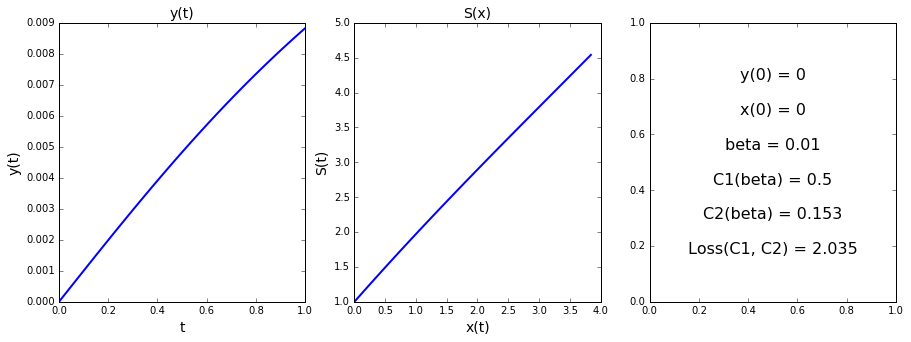

In [22]:
rho = lambda x: 6*x*(1-x)
S = lambda t: 4*t + cos(t)
z = lambda t: 3*t + sin(t)
f = FunctionF(expression="beta*(S-x)", beta=0.01, z_func=z, s_func=S)
y_0 = 0
x_0 = 0
T = 1
log = solver_logged(is_automatic=False, rho=rho, z=z, S=S, f=f, y_0=y_0, x_0=x_0, T=T)

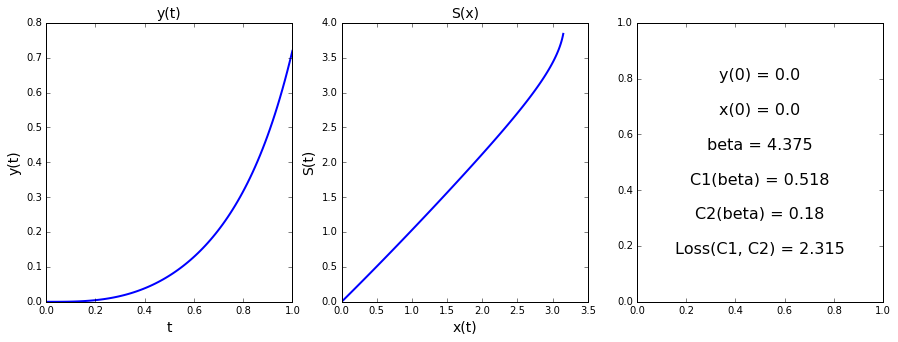

In [24]:
rho = lambda x: 6*x*(1-x)
S = lambda t: 3*t + sin(t)
z = lambda t: 4*t + cos(t)
bgrid = np.linspace(1, 10, 9)
fs = [FunctionF(expression="beta*(S-x)", beta=beta, z_func=z, s_func=S) for beta in bgrid]
y_0 = 0
x_0 = 0
T = 1
log = solver_logged(is_automatic=True, rho=rho, z=z, S=S, f=fs, y_0=y_0, x_0=x_0, T=T)

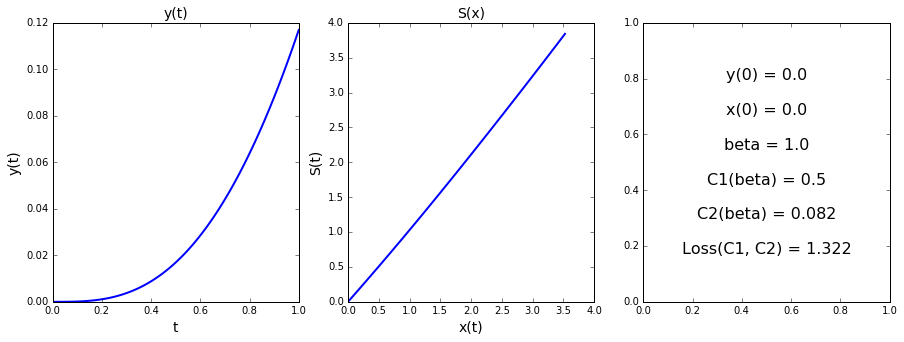

In [26]:
rho = lambda x: 6*x*(1-x)
S = lambda t: 3*t + sin(t)
z = lambda t: 4*t + cos(t)
bgrid = np.array([10**x for x in range(-10, 2)] + [-10**x for x in range(-10, 2)])
fs = [FunctionF(expression="beta*(S-x)", beta=beta, z_func=z, s_func=S) for beta in bgrid]
y_0 = 0
x_0 = 0
T = 1
log = solver_logged(is_automatic=True, rho=rho, z=z, S=S, f=fs, y_0=y_0, x_0=x_0, T=T)

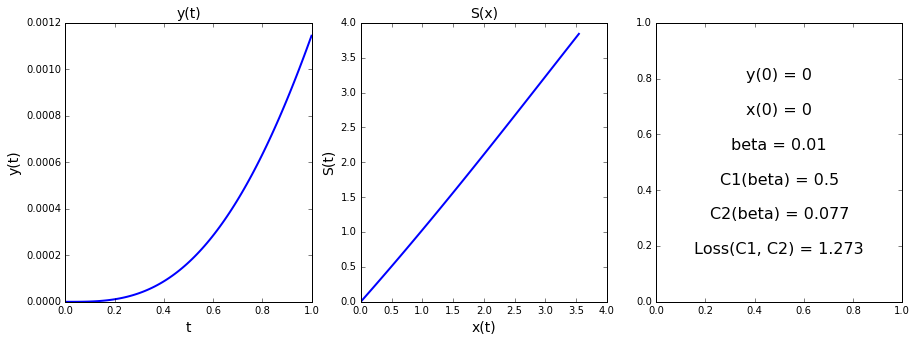

In [28]:
rho = lambda x: 6*x*(1-x)
S = lambda t: 3*t + sin(t)
z = lambda t: 4*t + cos(t)
f = FunctionF(expression="beta*(S-x)", beta=0.01, z_func=z, s_func=S)
y_0 = 0
x_0 = 0
T = 1
log = solver_logged(is_automatic=False, rho=rho, z=z, S=S, f=f, y_0=y_0, x_0=x_0, T=T)

In [30]:
rho = lambda x: 6*x*(1-x)
S = lambda t: 3*t
z = lambda t: 4*t
f = FunctionF(expression="beta*(S-x)", beta=1, z_func=z, s_func=S)
y_0 = 0
x_0 = 0
T = 1
log = solver_logged(is_automatic=False, rho=rho, z=z, f=f, S=S, y_0=y_0, x_0=x_0, T=T)

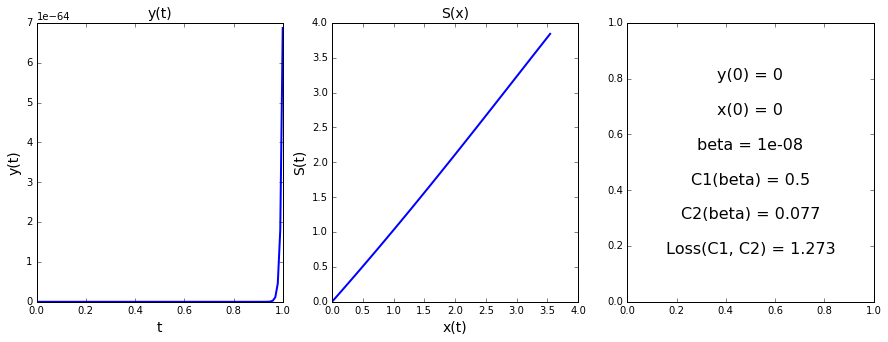

In [31]:
rho = lambda x: 6*x*(1-x)
S = lambda t: 3*t + sin(t)
z = lambda t: 4*t + cos(t)
f = FunctionF(expression="beta*(S-x)**100", beta=0.00000001, z_func=z, s_func=S)
y_0 = 0
x_0 = 0
T = 1
log = solver_logged(is_automatic=False, rho=rho, z=z, S=S, f=f, y_0=y_0, x_0=x_0, T=T)

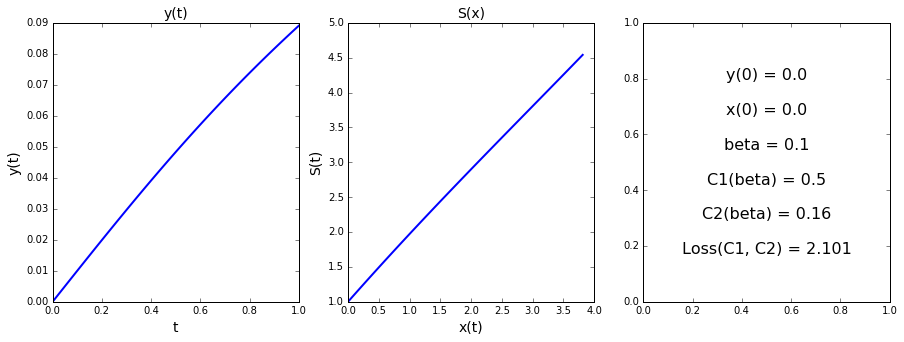

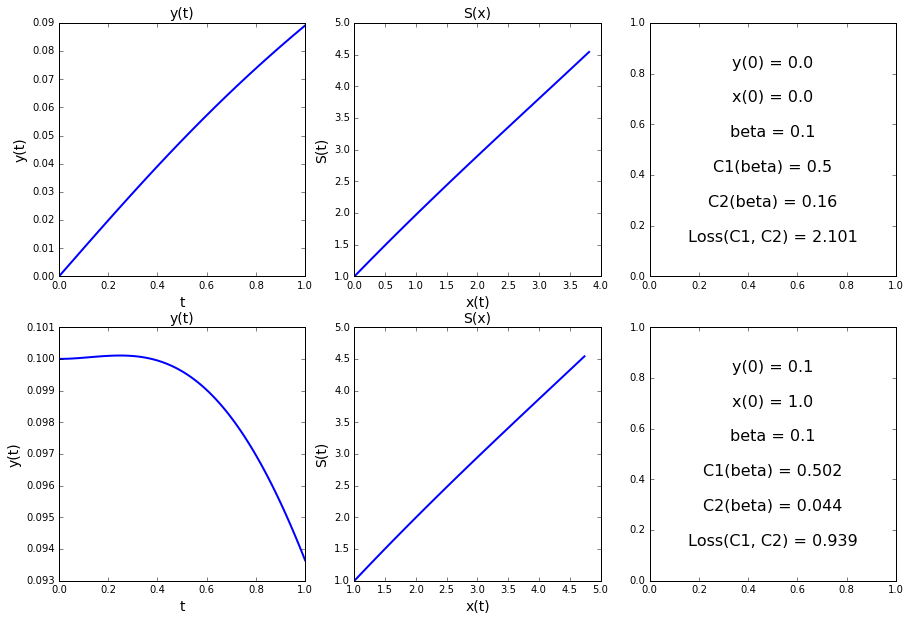

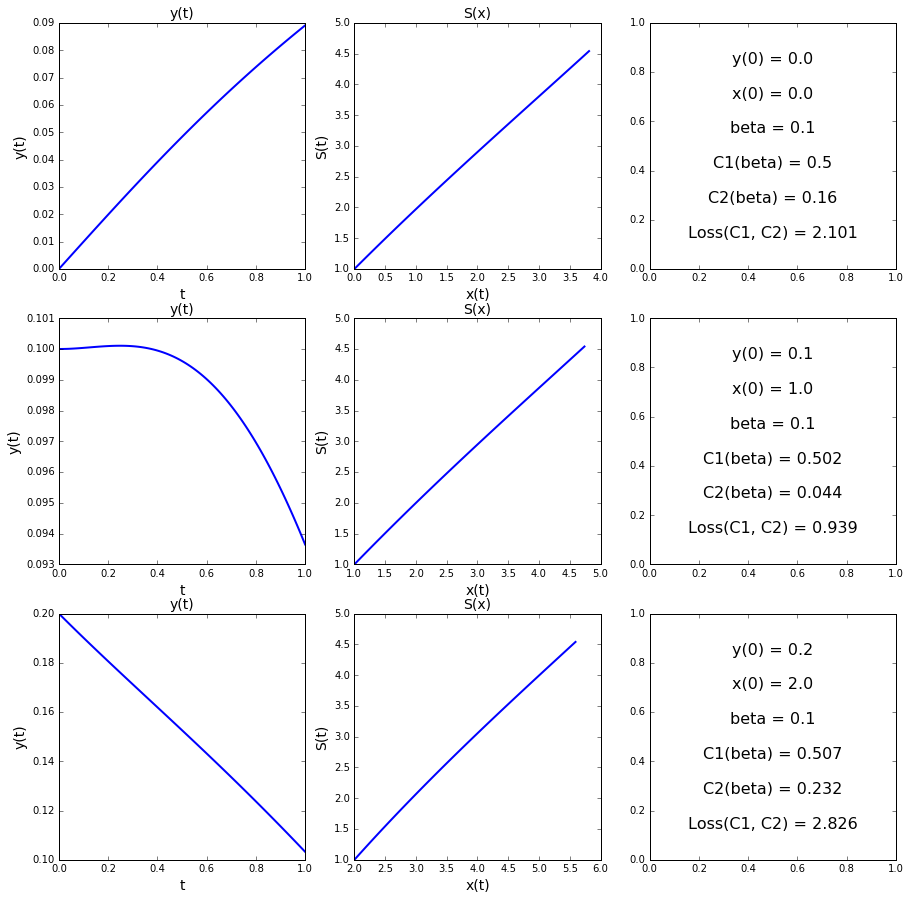

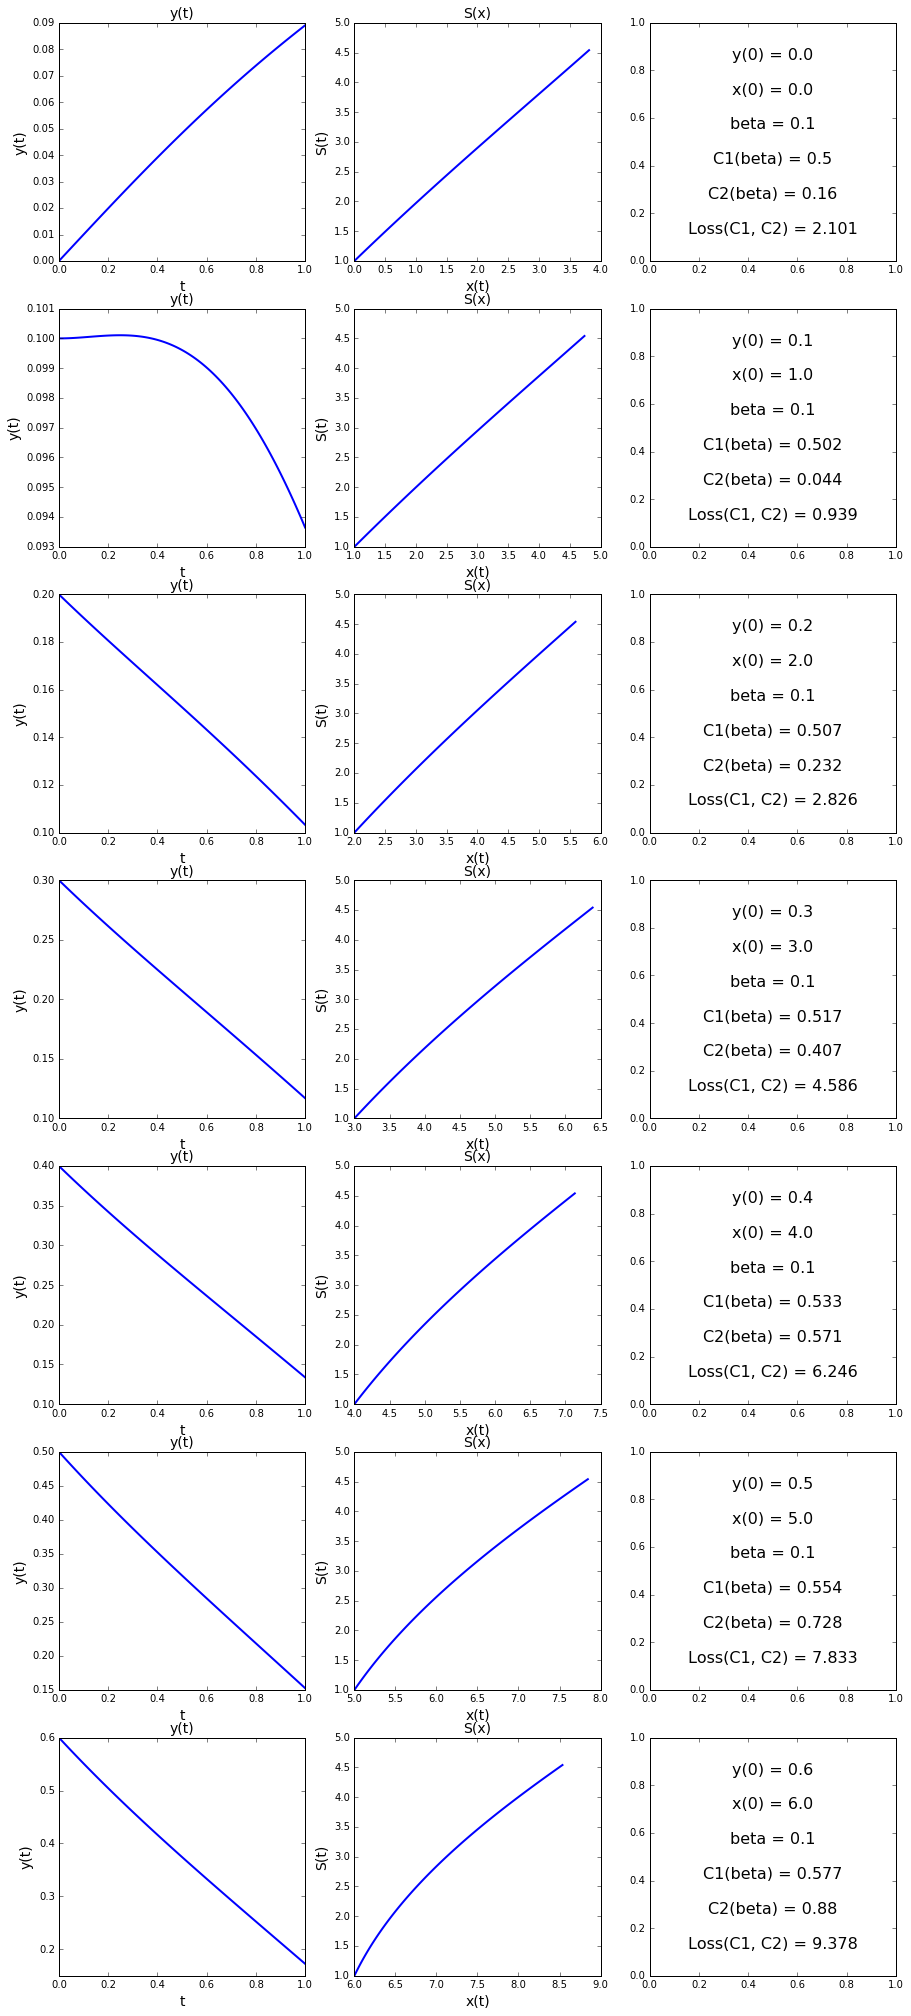

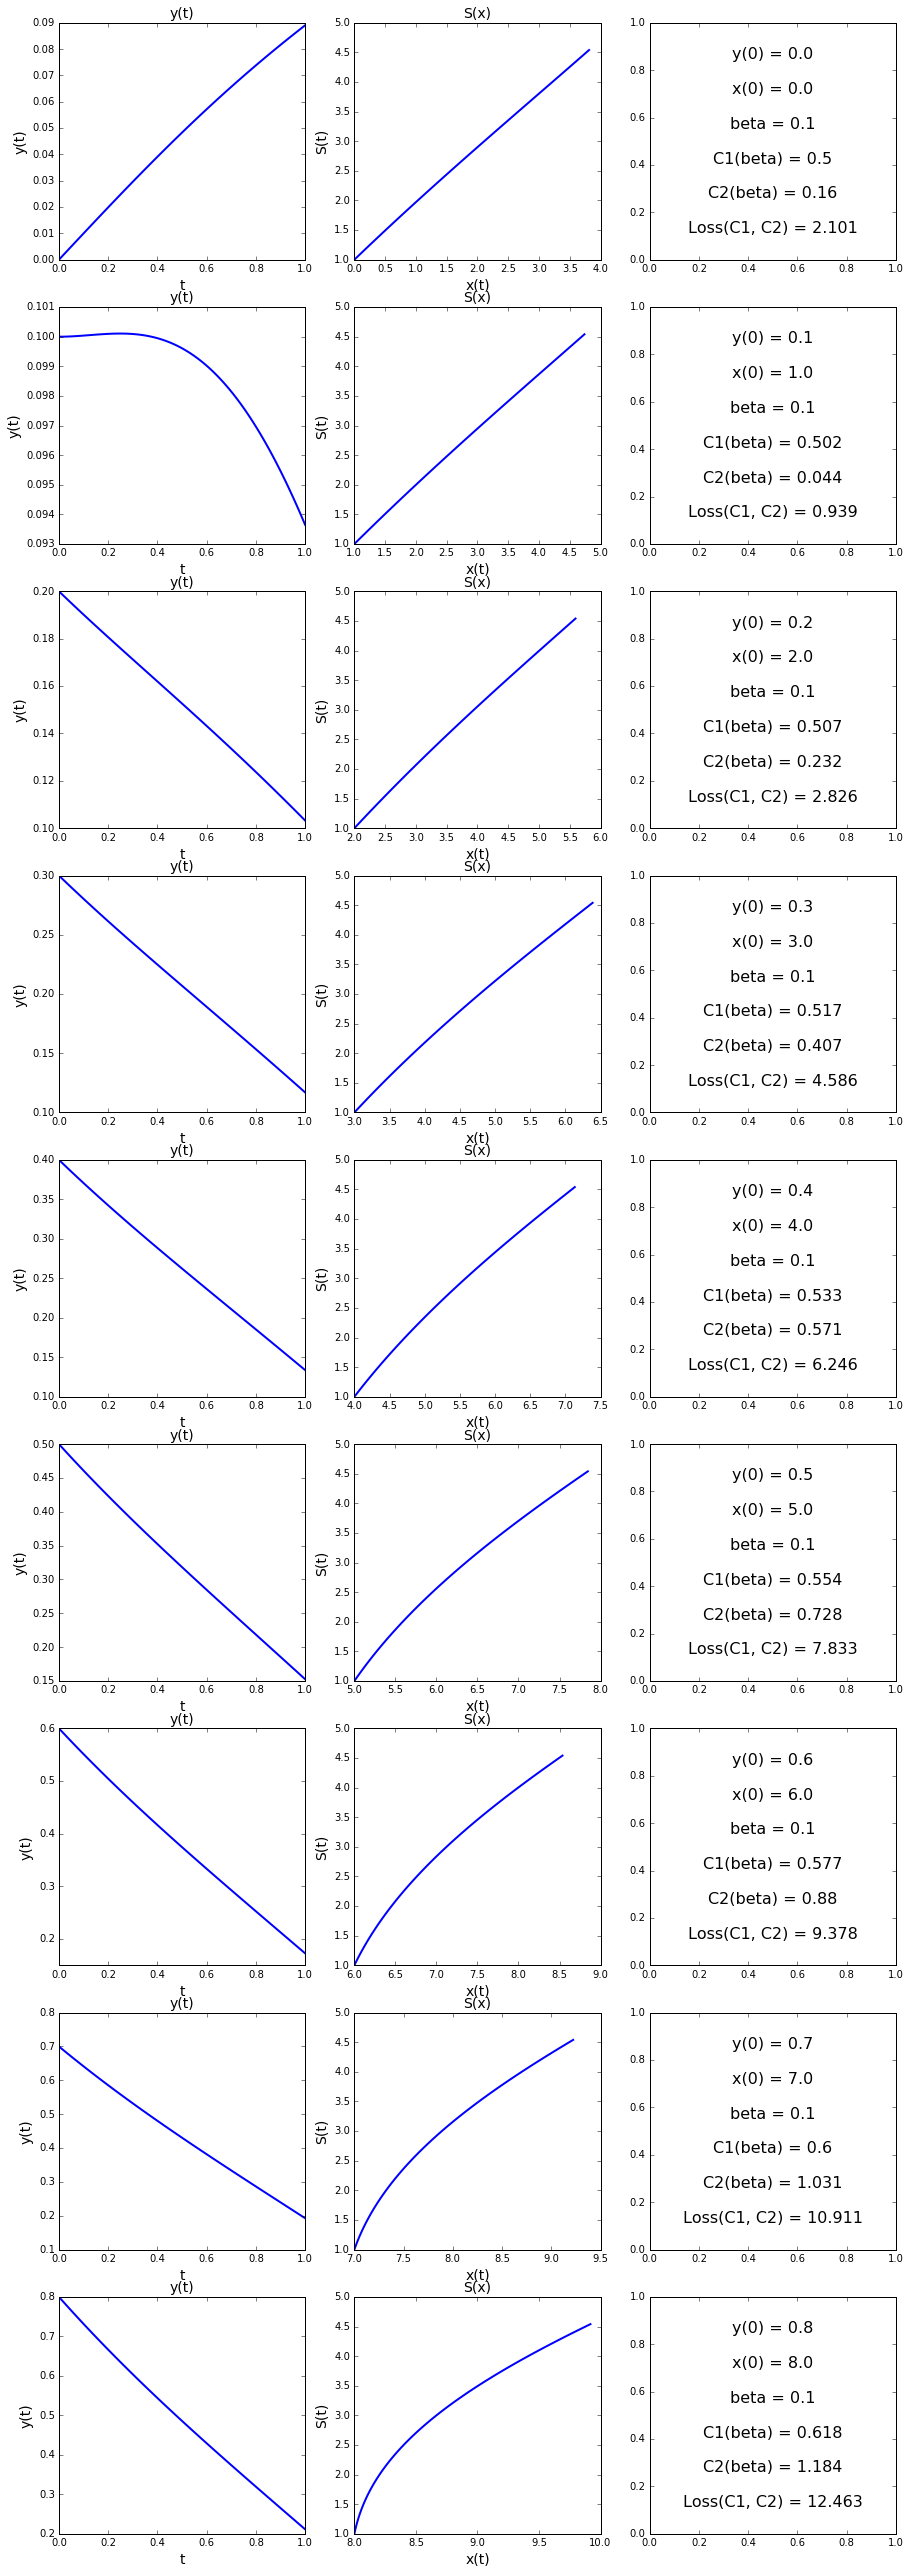

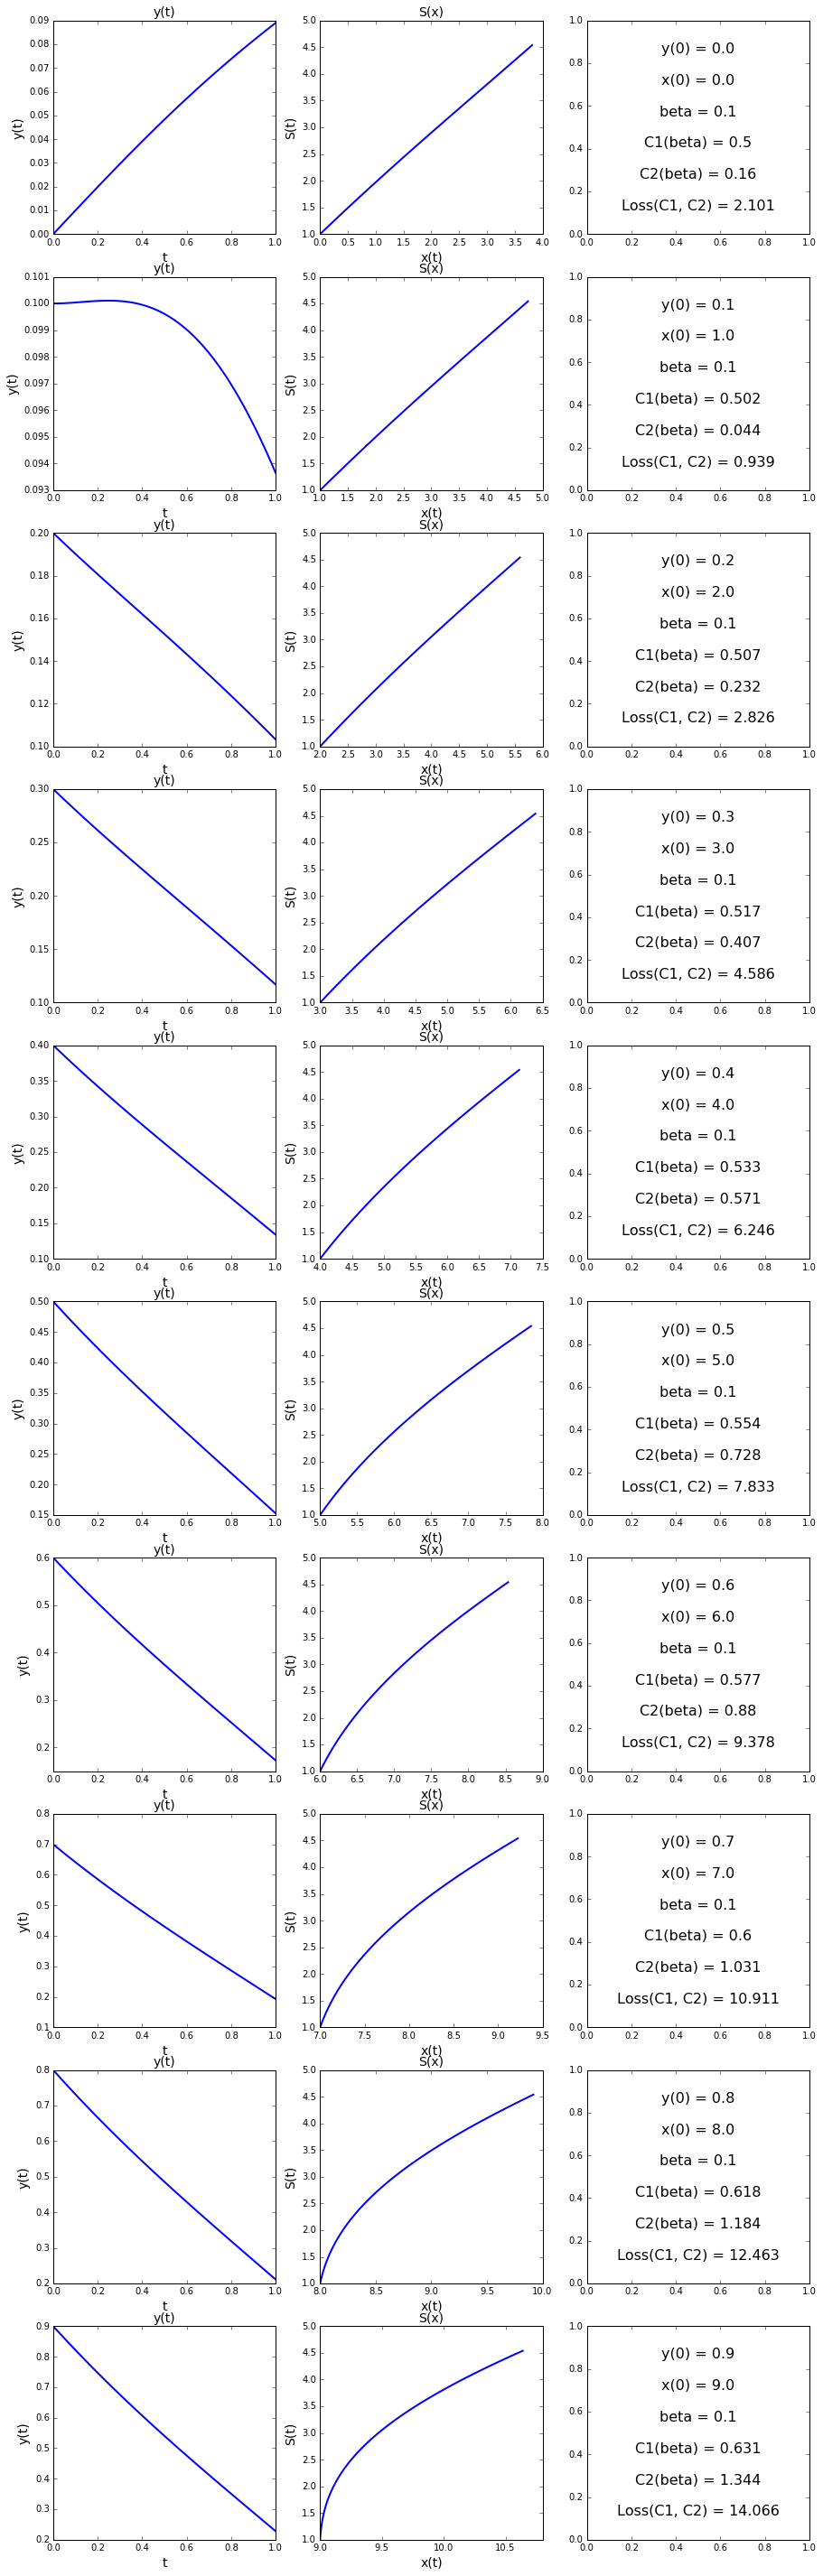

In [38]:
rho = lambda x: 6*x*(1-x)
S = lambda t: 4*t + cos(t)
z = lambda t: 3*t + sin(t)
bgrid = np.array([10**x for x in range(-10, 2)] + [-10**x for x in range(-10, 2)])
fs = [FunctionF(expression="beta*(S-x)", beta=beta, z_func=z, s_func=S) for beta in bgrid]
y_0 = 0
x_0 = 0
T = 1
log = solver_logged(is_automatic=True, rho=rho, z=z, S=S, f=fs, y_0=y_0, x_0=x_0, T=T)